In [77]:
#####################################################################################################
#####################################################################################################
####################### Import dependencies
#####################################################################################################
#####################################################################################################

import bovespa
import pandas as pd
import csv
import fnmatch
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from os import listdir, path
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [203]:
#####################################################################################################
#####################################################################################################
####################### Define constants and classes
#####################################################################################################
#####################################################################################################

# Constants
CONST_directory                            = "../data"
CONST_fdata_regex                          = "*.txt"
CONST_fcodes_not_regex                     = "\d\w|\d\d"
CONST_fcodes_regex                         = "\d"
CONST_ma_days                              = 21
CONST_sdv_times                            = 2
CONST_operation_start_days                 = 1
CONST_fig_x                                = 20
CONST_fig_y                                = 8

CONST_formula_label                        = "FORMULA"
CONST_date_label                           = "DATE"
CONST_ratio_label                          = "RATIO"
CONST_price_label                          = "PRICE"
CONST_cumulative_suffix_label              = "_CUMULATIVE"
CONST_buydate_label                        = "Buy Date:"
CONST_selldate_label                       = "Sell Date:"
CONST_file_label                           = "Arquivo:" 
CONST_stock1_label                         = "Stock 1:"
CONST_stock2_label                         = "Stock 2:"
CONST_bbands_upper_label                   = "BBANDS_UPPER"
CONST_bbands_middleupper_label             = "BBANDS_MIDDLEUPPER"
CONST_bbands_base_label                    = "BBANDS_BASE"
CONST_bbands_middlelower_label             = "BBANDS_MIDDLELOWER"
CONST_bbands_lower_label                   = "BBANDS_LOWER"
CONST_bbands_trend_label                   = "BBANDS_TREND"
CONST_bbands_result_label                  = "BBANDS_RESULT"
CONST_netincome_value_prefix_label         = "NETINCOME_VALUE_"
CONST_netincome_percent_prefix_label       = "NETINCOME_PERCENT_"
CONST_netincome_ratio_value_label          = "NETINCOME_VALUE_RATIO"
CONST_netincome_ratio_percent_label        = "NETINCOME_PERCENT_RATIO"

# Classes
class Indicator:
    @classmethod
    def netincome(self, df, price_attr, date_attr, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        
        Netincome = pd.Series(None, index = df.index, name = (kwargs.get("netincome_value_name") or "NETINCOME_VALUE"))
        Netincome_percent = pd.Series(None, index = df.index, name = (kwargs.get("netincome_percent_name") or "NETINCOME_PERCENT"))
        
        for idx, value in df.iterrows():
            if value[date_attr] > buy_date and value[date_attr] <= sell_date:
                Netincome[idx] = value[price_attr] - (df.loc[idx-1][price_attr]).item()
                Netincome_percent[idx] = Netincome[idx] * 100 / (df.loc[idx-1][price_attr]).item()
                
        return pd.concat([Netincome, Netincome_percent], join='outer', axis=1)
    
    @classmethod
    def netincome_with_ratio(self, df, stock1_price_attr, stock2_price_attr, date_attr, bb_ratio_attr, bb_base_attr, bb_trend_attr, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        
        Netincome = pd.Series(None, index = df.index, name = (kwargs.get("netincome_value_name") or "NETINCOME_VALUE_RATIO"))
        Netincome_percent = pd.Series(None, index = df.index, name = (kwargs.get("netincome_percent_name") or "NETINCOME_PERCENT_RATIO"))

        # It defines the first buy of stock for net income calculation
        last_date = (df[df[date_attr] == buy_date][date_attr]).item()
        if (df[df[date_attr] == last_date][bb_base_attr]).item() and ((df[df[date_attr] == last_date][bb_ratio_attr]).item() > (df[df[date_attr] == last_date][bb_base_attr]).item()):
            last_trend = 1
        else:
            last_trend = -1
        last_price = stock1_price_attr if last_trend == -1 else stock2_price_attr
        
        for idx, value in df.iterrows():
            if value[date_attr] > last_date and value[date_attr] <= sell_date:
                Netincome[idx] = value[last_price] - (df.loc[idx-1][last_price]).item()
                Netincome_percent[idx] = Netincome[idx] * 100 / (df.loc[idx-1][last_price]).item()
                
                # Buy stock 2 and sell stock 1
                if value[bb_trend_attr] == 1 and last_trend == -1:
                    last_trend = 1
                    last_date = value[date_attr]
                    last_price = stock2_price_attr
                elif value[bb_trend_attr] == -1 and last_trend == 1:
                    last_trend = -1
                    last_date = value[date_attr]
                    last_price = stock1_price_attr                    

        return pd.concat([Netincome, Netincome_percent], join='outer', axis=1)    
            
    @classmethod
    def bbands(self, df, price_attr, n, nstd, nresult, **kwargs):
        MA = pd.Series(df[price_attr].rolling(window=n).mean())
        MSD = pd.Series(df[price_attr].rolling(window=n).std())
        
        Base = pd.Series(MA, name = (kwargs.get("base_name") or "BASE"))
        Middle_upper = pd.Series(MA + MSD * nstd/2, name = (kwargs.get("middle_upper_name") or "MIDDLE_UPPER"))
        Middle_lower = pd.Series(MA - MSD * nstd/2, name = (kwargs.get("middle_lower_name") or "MIDDLE_LOWER"))
        Upper = pd.Series(MA + MSD * nstd, name = (kwargs.get("upper_name") or "UPPER"))
        Lower = pd.Series(MA - MSD * nstd, name = (kwargs.get("lower_name") or "LOWER"))        
        
        Trend = pd.Series(0, index = Lower.index, name = (kwargs.get("trend_name") or "TREND"))
        Result = pd.Series(None, index = Lower.index, name = (kwargs.get("result_name") or "RESULT"))
        
        last_result = None
        last_idx = None
        last_trend = None
        
        for idx, value in Upper.iteritems():
            if idx >= n:
                # Trend/Result calculation
                if ((last_trend != 1) and ((df[price_attr][idx] > Upper[idx]) or 
                    ((last_trend == -1) and ((idx - last_idx) >= nresult) and (df[price_attr][idx] > Middle_upper[idx])) or
                    ((last_trend == -1) and ((idx - last_idx) >= 2*nresult) and (df[price_attr][idx] > Base[idx])))):
                    Trend[idx] = 1   
                elif ((last_trend != -1) and ((df[price_attr][idx] < Lower[idx]) or 
                      ((last_trend == 1) and ((idx - last_idx) >= nresult) and (df[price_attr][idx] < Middle_lower[idx])) or
                      ((last_trend == 1) and ((idx - last_idx) >= 2*nresult) and (df[price_attr][idx] < Base[idx])))):
                    Trend[idx] = -1                                   
                    
                # Lower/Upper adjust based on trend    
                if (Trend[idx] == 1) and (Lower[idx] < Lower[idx-1]):
                    Lower[idx] = Lower[idx-1]
                elif (Trend[idx] == -1) and (Upper[idx] > Upper[idx-1]):
                    Upper[idx] = Upper[idx-1]
                
                # Update result
                if (Trend[idx] != 0):
                    Result[idx] = df[price_attr][idx]
                    last_result = Result[idx]
                    last_idx = idx
                    last_trend = Trend[idx]                    
                    
        return pd.concat([Upper, Middle_upper, Base, Middle_lower, Lower, Result, Trend], join='outer', axis=1)

class Parser:
    def __init__(self, inpt, output=None):
        self.input = inpt
        self.output = output

    @classmethod
    def convert_record_to_dict(self, query):
        for rec in query:
            yield rec.info

    def get_query(self):
        bf = bovespa.File(self.input)
        return bf.query()

    def get_dataframe(self):
        return pd.DataFrame(self.convert_record_to_dict(self.get_query()))
    
class Select:
    def __init__(self, option=None, dropdown=None):
        self.option = option
        self.dropdown = dropdown
        
    def get_dropdown(self, options, description="Option:"):
        if not self.dropdown:
            w = widgets.Dropdown(options=options,description=description,value=options[0])
            w.observe(self.on_change)
            self.dropdown = w
            self.option = w.value
        
        return self.dropdown
    
    def on_change(self, change):      
        if change.name == "value" and change.type == "change":
            self.option = change.new    
            
class Reader(Select):
    @classmethod
    def get_files(self, where, regex):
        return sorted([name for name in listdir(where) if re.compile(fnmatch.translate(regex), re.IGNORECASE).match(name)])

In [204]:
#####################################################################################################
#####################################################################################################
####################### Select Bovespa file
#####################################################################################################
#####################################################################################################

file = Select()
display(file.get_dropdown(Reader.get_files(CONST_directory, CONST_fdata_regex), CONST_file_label))

Dropdown(description='Arquivo:', options=('COTAHIST_A2007.TXT', 'COTAHIST_A2008.TXT', 'COTAHIST_A2009.TXT', 'C…

In [275]:
#####################################################################################################
#####################################################################################################
####################### Parse Bovespa file
#####################################################################################################
#####################################################################################################

p = Parser(path.join(CONST_directory, file.option))
d = p.get_dataframe()
codes = d.CODNEG

In [268]:
#####################################################################################################
#####################################################################################################
####################### Select Stock1 and Stock2
#####################################################################################################
#####################################################################################################

options = codes[
    np.logical_and(
        ~codes.str.contains(CONST_fcodes_not_regex),
        codes.str.contains(CONST_fcodes_regex)
    )].sort_values().unique()

stock1 = Select()
stock2 = Select()

display(stock1.get_dropdown(options, CONST_stock1_label))
display(stock2.get_dropdown(options, CONST_stock2_label))

Dropdown(description='Stock 1:', options=('AALR3', 'ABCB2', 'ABCB4', 'ABEV3', 'ABEVA7', 'ABEVE4', 'ABEVE5', 'A…

Dropdown(description='Stock 2:', options=('AALR3', 'ABCB2', 'ABCB4', 'ABEV3', 'ABEVA7', 'ABEVE4', 'ABEVE5', 'A…

In [269]:
#####################################################################################################
#####################################################################################################
####################### Select Buydate and Selldate
#####################################################################################################
#####################################################################################################

d_stock1 = d[codes == stock1.option]
d_stock1.index = range(len(d_stock1))
d_stock2 = d[codes == stock2.option]
d_stock2.index = range(len(d_stock2))

buy_date = Select()
sell_date = Select()

display(buy_date.get_dropdown(d_stock1.DATPRG, CONST_buydate_label))
display(sell_date.get_dropdown(d_stock1.DATPRG, CONST_selldate_label))

Dropdown(description='Buy Date:', options=(datetime.date(2018, 1, 2), datetime.date(2018, 1, 3), datetime.date…

Dropdown(description='Sell Date:', options=(datetime.date(2018, 1, 2), datetime.date(2018, 1, 3), datetime.dat…

In [270]:
#####################################################################################################
#####################################################################################################
####################### Generate Dataframe
#####################################################################################################
#####################################################################################################

CONST_formula = f"{stock1.option}/{stock2.option}"

df = pd.DataFrame()
df[CONST_date_label] = d_stock1.DATPRG
df[CONST_formula_label] = CONST_formula
df[CONST_ratio_label] = d_stock1.PREULT/d_stock2.PREULT
df[stock1.option] = d_stock1.PREULT
df[stock2.option] = d_stock2.PREULT

bbands = Indicator.bbands(
    df, CONST_ratio_label, CONST_ma_days, CONST_sdv_times, CONST_operation_start_days,
    upper_name=CONST_bbands_upper_label,
    middle_upper_name=CONST_bbands_middleupper_label,
    base_name=CONST_bbands_base_label,
    middle_lower_name=CONST_bbands_middlelower_label,
    lower_name=CONST_bbands_lower_label,
    trend_name=CONST_bbands_trend_label,
    result_name=CONST_bbands_result_label
)

netincome_stock1_value_name = CONST_netincome_value_prefix_label + stock1.option
netincome_stock1 = Indicator.netincome(
    df, 
    stock1.option, 
    CONST_date_label,
    buy_date = buy_date.option, 
    sell_date = sell_date.option,
    netincome_value_name = netincome_stock1_value_name, 
    netincome_percent_name = (CONST_netincome_percent_prefix_label + stock1.option)
)

netincome_stock2_value_name = CONST_netincome_value_prefix_label + stock2.option
netincome_stock2 = Indicator.netincome(
    df, 
    stock2.option, 
    CONST_date_label, 
    buy_date = buy_date.option,
    sell_date = sell_date.option,
    netincome_value_name = netincome_stock2_value_name, 
    netincome_percent_name = (CONST_netincome_percent_prefix_label + stock2.option)
)

df = pd.merge(df, bbands, left_index=True, right_index=True)
df = pd.merge(df, netincome_stock1, left_index=True, right_index=True)
df = pd.merge(df, netincome_stock2, left_index=True, right_index=True)

netincome_ratio = Indicator.netincome_with_ratio(
    df, 
    stock1.option, 
    stock2.option, 
    CONST_date_label, 
    CONST_ratio_label, 
    CONST_bbands_base_label, 
    CONST_bbands_trend_label,
    buy_date = buy_date.option, 
    sell_date = sell_date.option, 
    netincome_value_name = CONST_netincome_ratio_value_label, 
    netincome_percent_name = CONST_netincome_ratio_percent_label
)

df = pd.merge(df, netincome_ratio, left_index=True, right_index=True)

df[(netincome_stock1_value_name + CONST_cumulative_suffix_label)]       = df[netincome_stock1_value_name].cumsum()
df[(netincome_stock2_value_name + CONST_cumulative_suffix_label)]       = df[netincome_stock2_value_name].cumsum()
df[(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)] = df[CONST_netincome_ratio_value_label].cumsum()

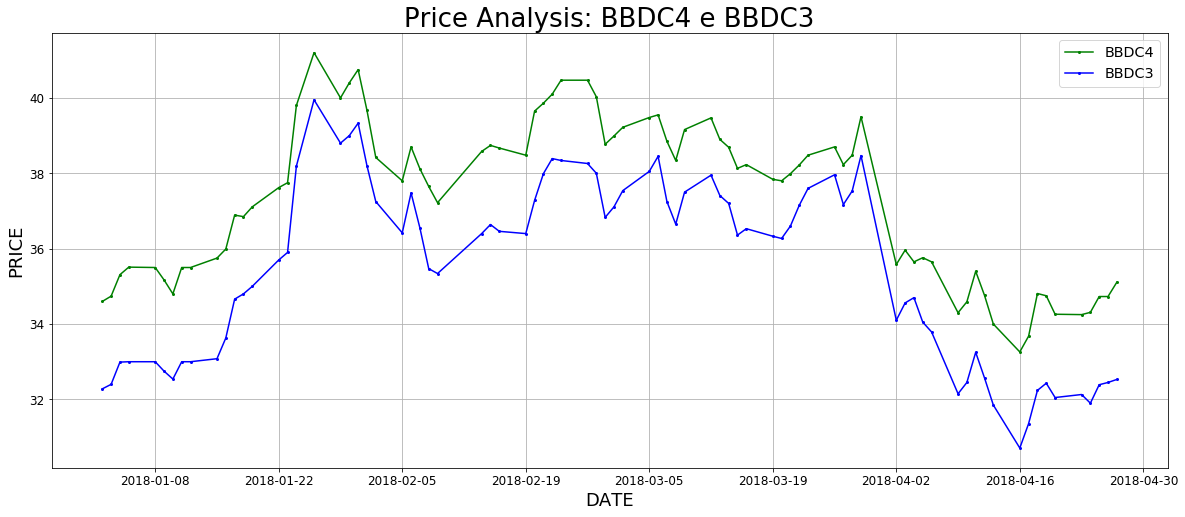

In [271]:
#####################################################################################################
#####################################################################################################
####################### Price Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(df[CONST_date_label], df[stock1.option], marker='o', markersize=2, color='green')
ax.plot(df[CONST_date_label], df[stock2.option], marker='o', markersize=2, color='blue')

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel(CONST_price_label, size=18)
ax.set_autoscale_on(True)
ax.set_title("Price Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize="x-large")

# fig.savefig("test.png")
plt.show()

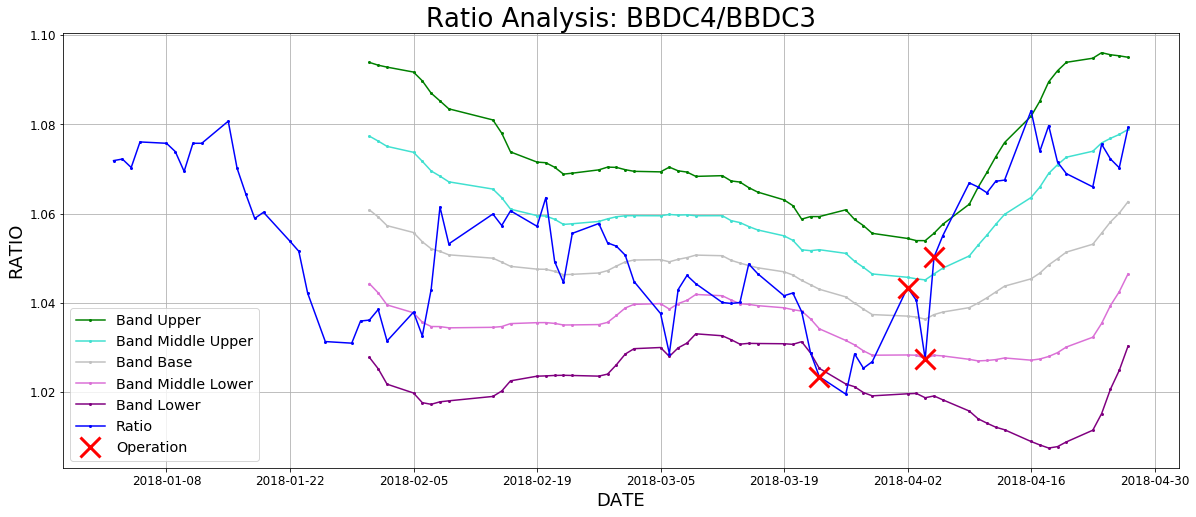

In [272]:
#####################################################################################################
#####################################################################################################
####################### Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(df[CONST_date_label], df[CONST_bbands_upper_label], marker='o', markersize=2, color='green', label='Band Upper')
ax.plot(df[CONST_date_label], df[CONST_bbands_middleupper_label], marker='o', markersize=2, ls='solid', color='turquoise', label='Band Middle Upper')
ax.plot(df[CONST_date_label], df[CONST_bbands_base_label], marker='o', markersize=2, color='silver', label='Band Base')
ax.plot(df[CONST_date_label], df[CONST_bbands_middlelower_label], marker='o', markersize=2, ls='solid', color='orchid', label='Band Middle Lower')
ax.plot(df[CONST_date_label], df[CONST_bbands_lower_label], marker='o', markersize=2, color='purple', label='Band Lower')
ax.plot(df[CONST_date_label], df[CONST_ratio_label], marker='o', markersize=2, color='blue', label='Ratio')
ax.plot(df[CONST_date_label], df[CONST_bbands_result_label], marker='x', ls='None', ms=20, mec='r', mew=3, color='r', label='Operation')

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel(CONST_ratio_label, size=18)
ax.set_autoscale_on(True)
ax.set_title("Ratio Analysis: " + CONST_formula, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

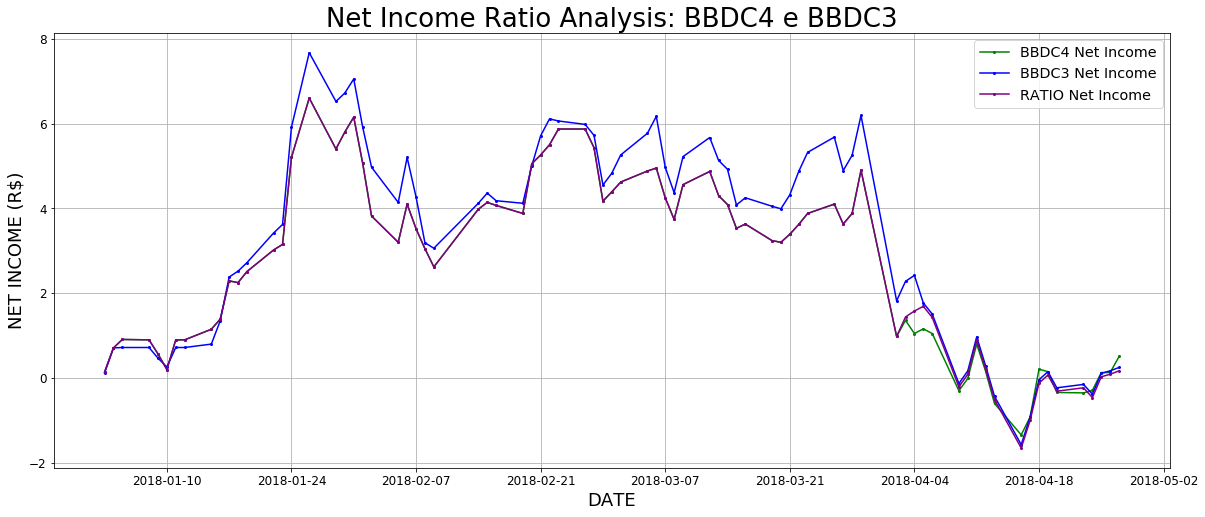

In [273]:
#####################################################################################################
#####################################################################################################
####################### Net Income Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(df[CONST_date_label], df[(netincome_stock1_value_name + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='green', label=(stock1.option + ' Net Income'))
ax.plot(df[CONST_date_label], df[(netincome_stock2_value_name + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='blue', label=(stock2.option + ' Net Income'))
ax.plot(df[CONST_date_label], df[(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='purple', label=(CONST_ratio_label + ' Net Income'))

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel("NET INCOME (R$)", size=18)
ax.set_autoscale_on(True)
ax.set_title("Net Income Ratio Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

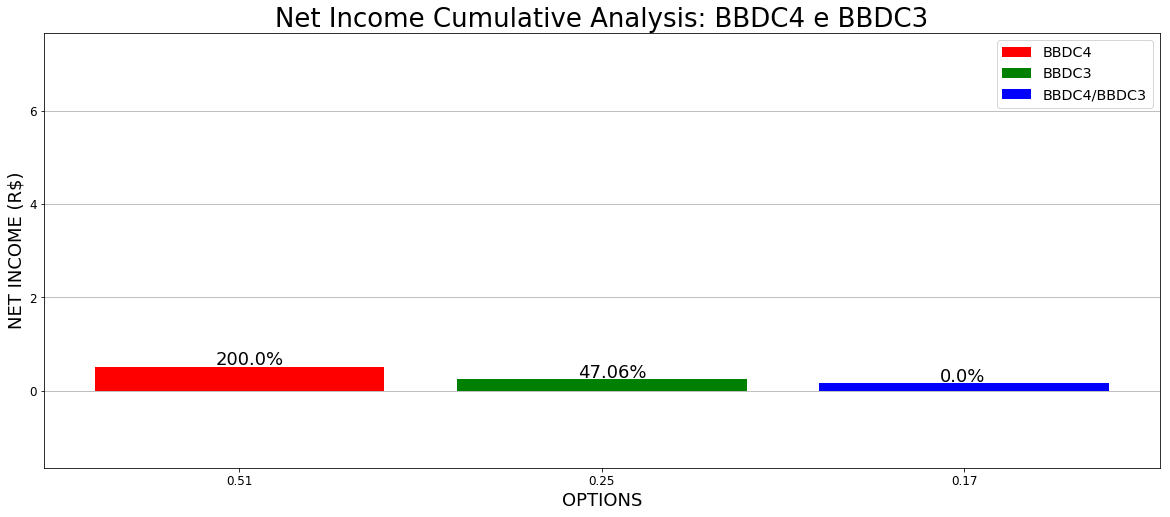

In [274]:
#####################################################################################################
#####################################################################################################
####################### Net Income Cumulative Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()

ind = np.arange(3)
step = ind[1] - ind[0]

values = [
    df[np.logical_and(df[CONST_date_label] >= buy_date.option, df[CONST_date_label] <= sell_date.option)][netincome_stock1_value_name].sum(),
    df[np.logical_and(df[CONST_date_label] >= buy_date.option, df[CONST_date_label] <= sell_date.option)][netincome_stock2_value_name].sum(),
    df[np.logical_and(df[CONST_date_label] >= buy_date.option, df[CONST_date_label] <= sell_date.option)][CONST_netincome_ratio_value_label].sum()    
]

rects = ax.bar(ind, values)

rects[0].set_facecolor('r')
rects[1].set_facecolor('g')
rects[2].set_facecolor('b')

ymin = min(
    df[np.logical_and(df[CONST_date_label] >= buy_date.option, df[CONST_date_label] <= sell_date.option)][(netincome_stock1_value_name + CONST_cumulative_suffix_label)].min(),
    df[np.logical_and(df[CONST_date_label] >= buy_date.option, df[CONST_date_label] <= sell_date.option)][(netincome_stock2_value_name + CONST_cumulative_suffix_label)].min(),
    df[np.logical_and(df[CONST_date_label] >= buy_date.option, df[CONST_date_label] <= sell_date.option)][(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)].min()
)

ymax = max(
    df[np.logical_and(df[CONST_date_label] >= buy_date.option, df[CONST_date_label] <= sell_date.option)][(netincome_stock1_value_name + CONST_cumulative_suffix_label)].max(),
    df[np.logical_and(df[CONST_date_label] >= buy_date.option, df[CONST_date_label] <= sell_date.option)][(netincome_stock2_value_name + CONST_cumulative_suffix_label)].max(),
    df[np.logical_and(df[CONST_date_label] >= buy_date.option, df[CONST_date_label] <= sell_date.option)][(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)].max()
)

ax.set_ylim([ymin, ymax])
ax.set_ylabel('NET INCOME (R$)', size=18)
ax.set_yscale
ax.set_xlabel('OPTIONS', size=18)
ax.set_xticks(ind)
ax.set_xticklabels([round(x, 2) for x in values], size=50)
ax.set_title("Net Income Cumulative Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.legend((s1, s2, r), (stock1.option, stock2.option, CONST_formula), fontsize='x-large')

for rect in rects:
    y = rect.get_height()
    x = rect.get_x()
    text = str(round(((y-min(values))/abs(min(values)))*100, 2)) + "%"
    ax.text(x + step/len(values), 1.1*y, text, fontsize=18)

fig.set_size_inches(CONST_fig_x, CONST_fig_y)
ax.set_autoscale_on(True)
ax.tick_params(labelsize="large")
ax.grid(axis="y")

# fig.savefig("test.png")
plt.show()